# Description

Explore research backtest results.

**Note**: use `dataflow/model/scripts/run_backtest_analysis_template.py` and `dataflow/model/notebooks/Master_backtest_analysis.ipynb` for standard backtest analysis.

This notebook is used for free-form analysis and hypotheses testing, does not save the resulting backtest portfolio, and is not as strictly maintained.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_utils as obccccut

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-af638c8d-43ae-4818-93c8-264e7d0c7249.json'
INFO  # Git
  branch_name='CMTask9029_update_the_Toy_research_backtest_analyzer_notebook'
  hash='0c7be5001'
  # Last commits:
    * 0c7be5001 Sonaal   CmampTask9065_Remove_delisted_symbol_RNDRUSDT_from_universe (#9066) (17 minutes ago) Tue Jul 16 14:19:46 2024  (HEAD -> CMTask9029_update_the_Toy_research_backtest_analyzer_notebook, origin/master, origin/HEAD, origin/CMTask9029_update_the_Toy_research_backtest_analyzer_notebook, master)
    * a092480f6 Danya Tikhomirov CMTask9041: Fix the superslow test (#9061)                        (   6 hours ago) Tue Jul 16 08:53:20 2024  (origin/CmampTask8950_Test_privatelink_endpoint_compatibility_with_CCXT)
    * b4405ea75 Juraj Smeriga CmampTask9018_Run_a_crypto.com_broker_only_run_on_Airflow_and_check_experiment_notebooks (#9044) (   7 hours ago) Tue Jul 16 07:42:09 2024           
# Machi

# Build the config dict

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    amp_dir = hgit.get_amp_abs_path()
    dir_name = os.path.join(
        amp_dir,
        "/shared_data/backtest.danya/build_tile_configs.C13a.ccxt_v7_5-all.2T.2024-01-22_2024-07-08.ins.run0/tiled_results",
    )
    # Create a subfolder to store portfolio metrics.
    # The subfolder is marked by the datetime of the run, e.g.
    # "build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-01-01_2024-03-20.ins.run0/portfolio_dfs/20240326_131724".
    default_config_dict = {
        "dir_name": dir_name,
        "start_date": datetime.date(2023, 1, 22),
        "end_date": datetime.date(2024, 7, 8),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "D",
        "rule": "2T",
        "forecast_evaluator_class_name": "ForecastEvaluatorFromPrices",
        "im_client_config": {
            "universe_version": "v7.5",
            "root_dir": "s3://cryptokaizen-data.preprod/tokyo/v3",
            "partition_mode": "by_year_month",
            "dataset": "bid_ask",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            # "resample_1min": False,
            "version": "v2_0_0",
            # Make sure it is related to `universe_version`.
            "download_universe_version": "v7_5",
            "tag": "resampled_1min",
        },
        "annotate_forecasts_kwargs": {
            "style": "longitudinal",
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
            "target_dollar_risk_per_name": 1.0,
            "modulate_using_prediction_magnitude": True,
            "prediction_abs_threshold": 0.0,
        },
        "forecast_evaluator_kwargs": {
            "price_col": "bid_ask_midpoint.open",
            "volatility_col": "vol_in_bps",
            "prediction_col": "f1",
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        # Uncomment and provide config key and values to
        # perform a parameter sweep.
        #         "sweep_param": {
        #             "keys": (
        #                 "forecast_evaluator_kwargs",
        #                 "price_col",
        #             ),
        #             "values": [
        #                 "open",
        #             ],
        #         },
    }
    # Add asset_id_to_share_decimals based on the `quantization` parameter:
    if not default_config_dict["annotate_forecasts_kwargs"]["quantization"]:
        asset_id_to_share_decimals = obccccut.get_asset_id_to_share_decimals(
            "amount_precision"
        )
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = asset_id_to_share_decimals
    else:
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = None
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/backtest.danya/build_tile_configs.C13a.ccxt_v7_5-all.2T.2024-01-22_2024-07-08.ins.run0/tiled_results
start_date: 2023-01-22
end_date: 2024-07-08
asset_id_col: asset_id
pnl_resampling_frequency: D
rule: 2T
forecast_evaluator_class_name: ForecastEvaluatorFromPrices
im_client_config: 
  universe_version: v7.5
  root_dir: s3://cryptokaizen-data.preprod/tokyo/v3
  partition_mode: by_year_month
  dataset: bid_ask
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v2_0_0
  download_universe_version: v7_5
  tag: resampled_1min
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 1.0
  modulate_using_prediction_magnitude: True
  prediction_abs_threshold: 0.0
  asset_id_to_share_decimals: None
forecast_evaluator_kwargs: 
  price_col: bid_ask_midp

# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
2507301697,1,7,7,8.2 MB
2874967820,1,7,7,8.3 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2024 1                2  923.1 KB
     2                2    3.4 MB
     3                2    3.6 MB
     4                2    3.5 MB
     5                2    3.6 MB
     6                2    1.6 MB
     7                2   65.2 KB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[2507301697, 2874967820]

## Load tile data

In [9]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [11]:
tile_df.columns.levels[0].to_list()

['bid_ask_midpoint.close',
 'bid_ask_midpoint.mean',
 'bid_ask_midpoint.open',
 'bid_ask_midpoint_var',
 'f1',
 'half_spread.mean',
 'half_spread_in_bps',
 'month',
 'rets_in_bps',
 'vol_in_bps',
 'year']

In [12]:
tile_df.head(3)

bid_ask_midpoint.close            bid_ask_midpoint.mean              bid_ask_midpoint.open            bid_ask_midpoint_var                    f1            half_spread.mean            half_spread_in_bps                 month            rets_in_bps            vol_in_bps                  year           
asset_id                              2507301697 2874967820            2507301697   2874967820            2507301697 2874967820           2507301697 2874967820 2507301697 2874967820       2507301697 2874967820         2507301697 2874967820 2507301697 2874967820  2507301697 2874967820 2507301697 2874967820 2507301697 2874967820
end_ts                                                                                                                                                                                                                                                                                                                                  
2024-01-23 11:30:00+00:00               38781.25   2222.000          38816.423300  2223.773587              38829.15   2225.205             850.8400   4.270575        NaN        NaN         0.317709   0.016655           0.081849   0.074893        1.0        1.0  -12.336093 -14.403167   7.514644   9.292929     2024.0     2024.0
2024-01-23 11:32:00+00:00               38839.65   2222.175          38826.844583  2222.912179              38781.55   2222.000            2888.4450   9.112225        NaN        NaN         1.909917   0.103529           0.491906   0.465737        1.0        1.0   14.981351   0.787579  13.842035  13.579692     2024.0     2024.0
2024-01-23 11:34:00+00:00               38853.80   2222.320          38837.337958  2221.795025              38839.65   2222.175            2200.8075   9.769975        NaN        NaN         0.661875   0.022550           0.170422   0.101495        1.0        1.0    3.643184   0.652514  12.079295  14.068336     2024.0     2024.0

# Compute and save portfolio bar metrics

In [13]:
# Get configs sweeping over parameter.
config_dict = dtfmod.build_research_backtest_analyzer_config_sweep(default_config)
print(config_dict.keys())

dict_keys(['default_config'])


In [14]:
portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = dtfmod.get_forecast_evaluator(
            config["forecast_evaluator_class_name"],
            **config["forecast_evaluator_kwargs"].to_dict(),
        )
        portfolio_df, bar_metrics = fep.annotate_forecasts(
            tile_df,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["forecast_evaluator_kwargs"]["price_col"],
            config["forecast_evaluator_kwargs"]["volatility_col"],
            config["forecast_evaluator_kwargs"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)

INFO  spread is `None`; imputing spread_lower_bound=0.000100


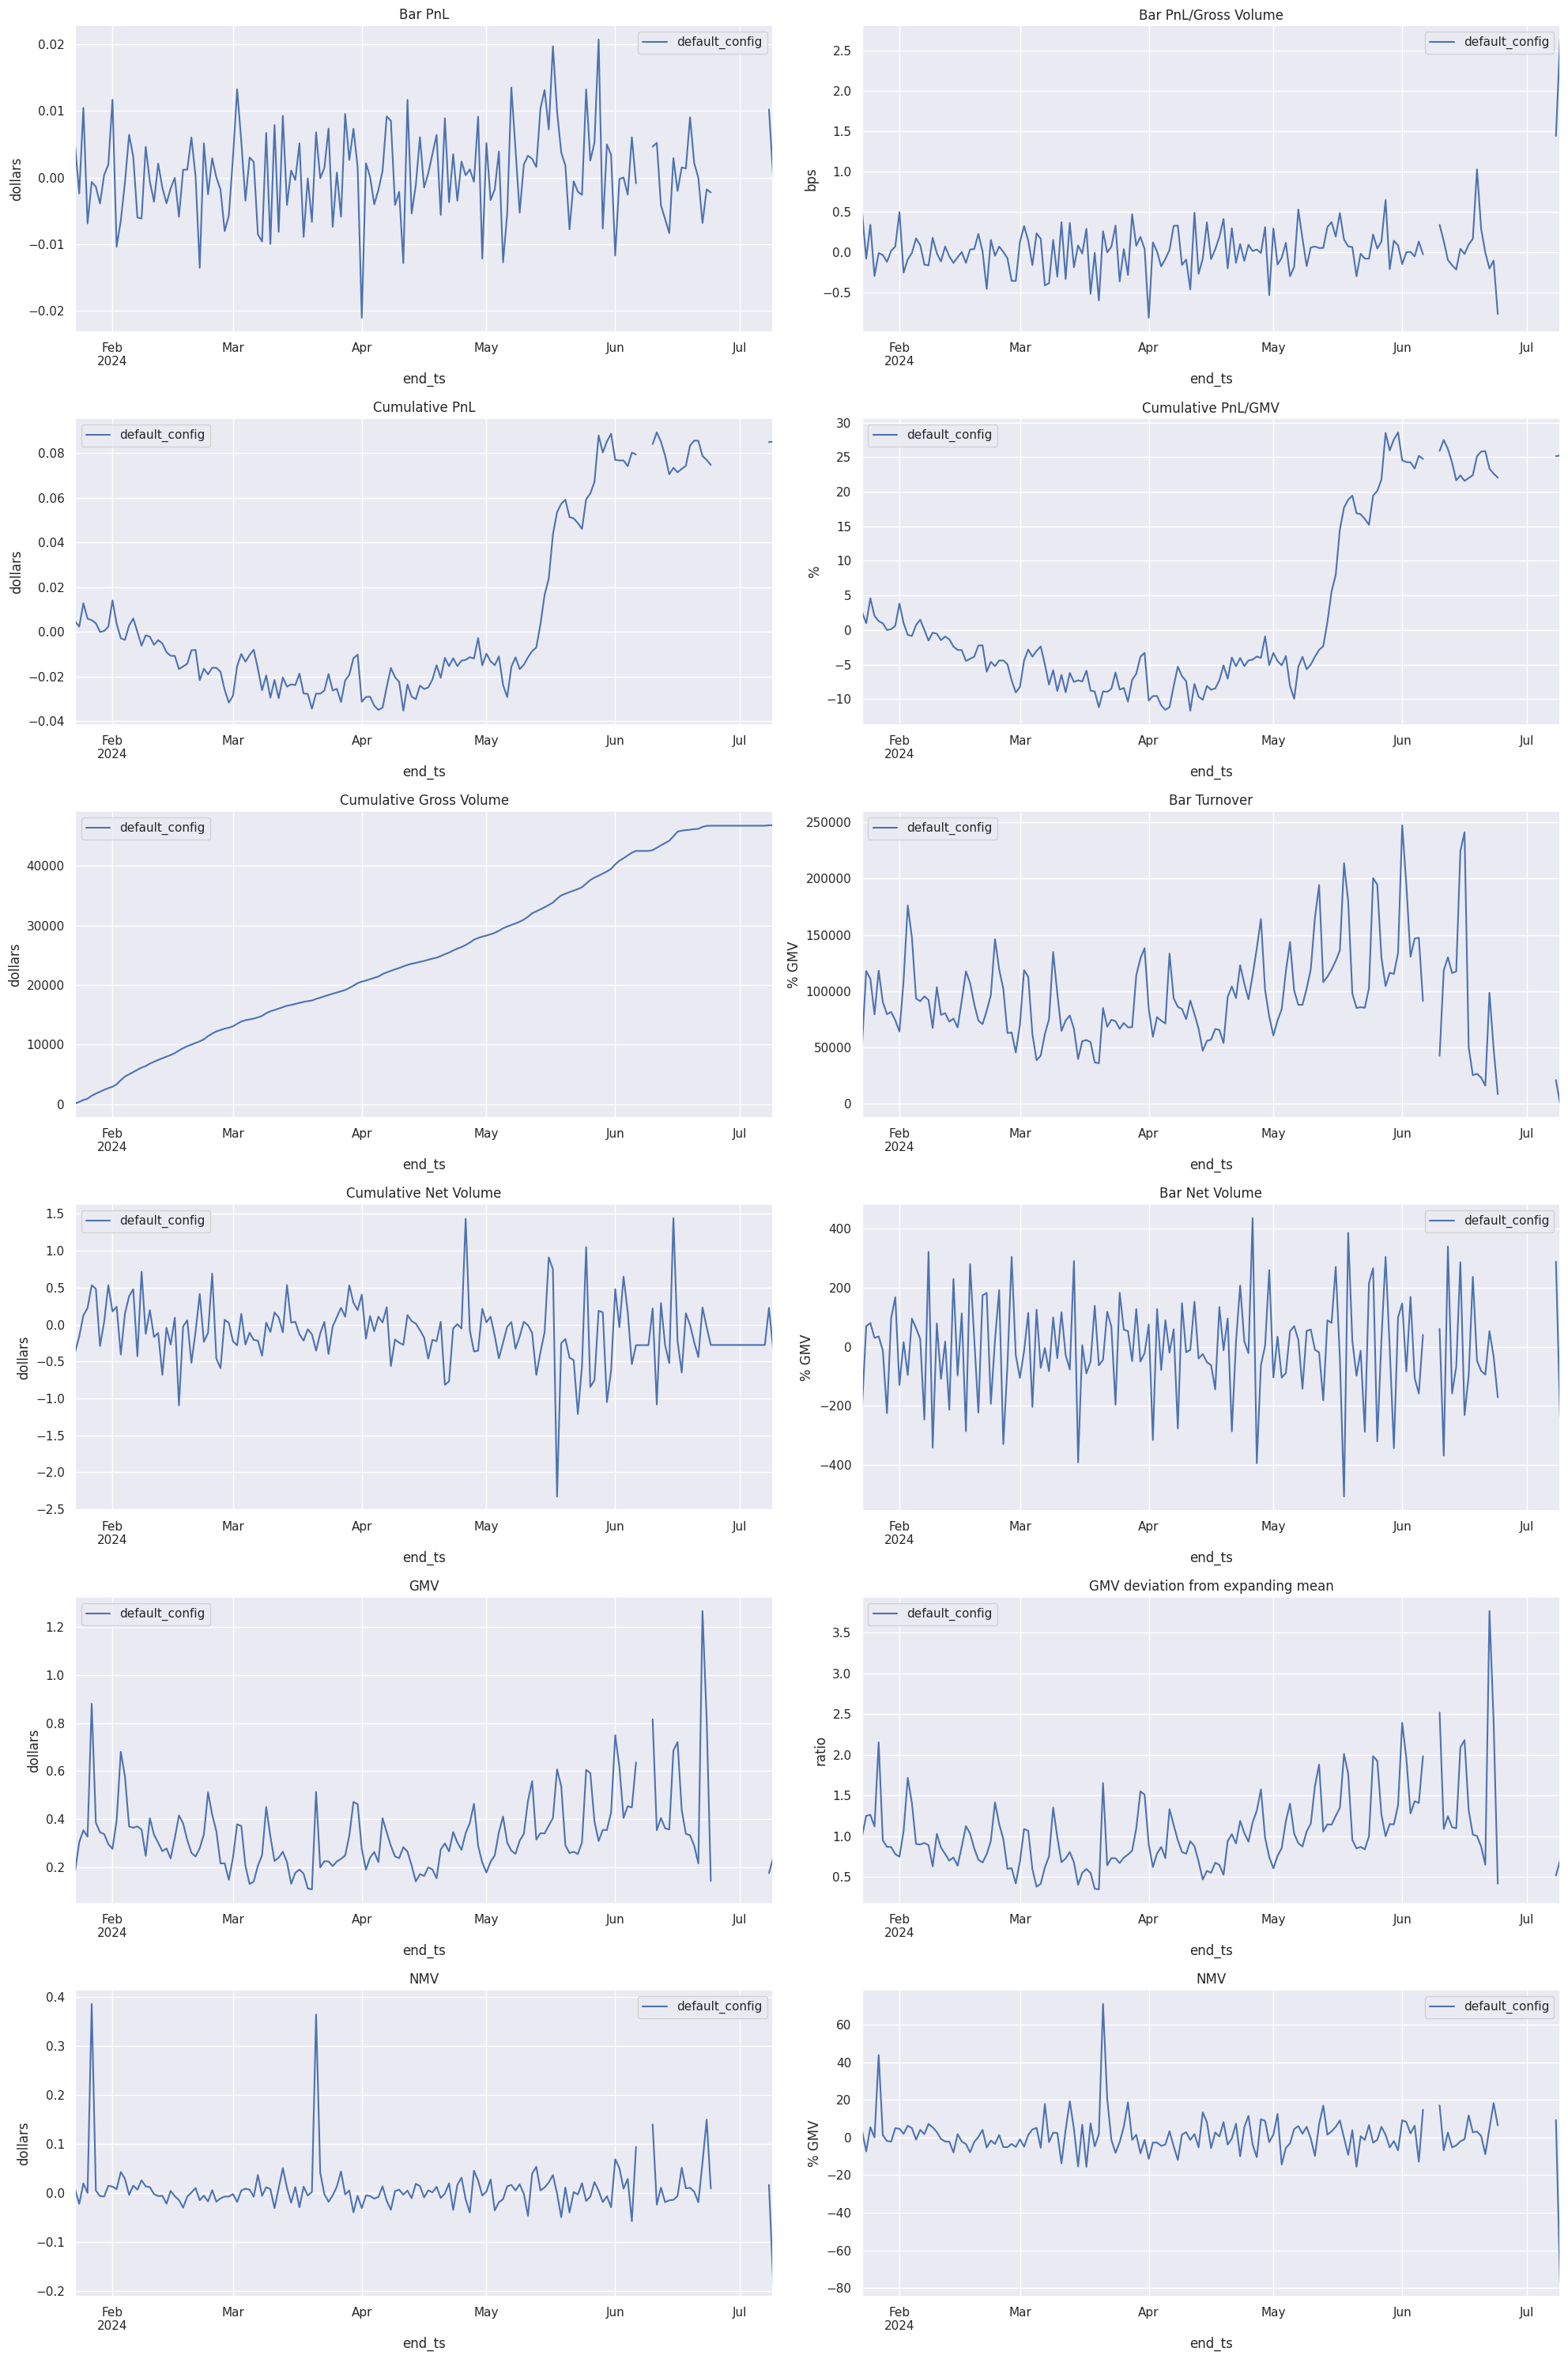

In [15]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df, freq=default_config["pnl_resampling_frequency"]
)

,pnl,pnl_in_bps,sgn_corr,corr
prediction,,,,
"(-inf, -0.842]",1.316949e-06,0.061690,-0.006835,0.001916
"(-0.842, -0.253]",-1.815003e-07,-0.033311,-0.014672,0.000047
"(-0.253, 0.253]",4.449563e-07,0.472312,-0.002679,0.001902
"(0.253, 0.842]",8.365814e-07,0.137592,0.012476,0.002374
"(0.842, inf]",-1.582170e-07,0.036064,0.007423,-0.000842


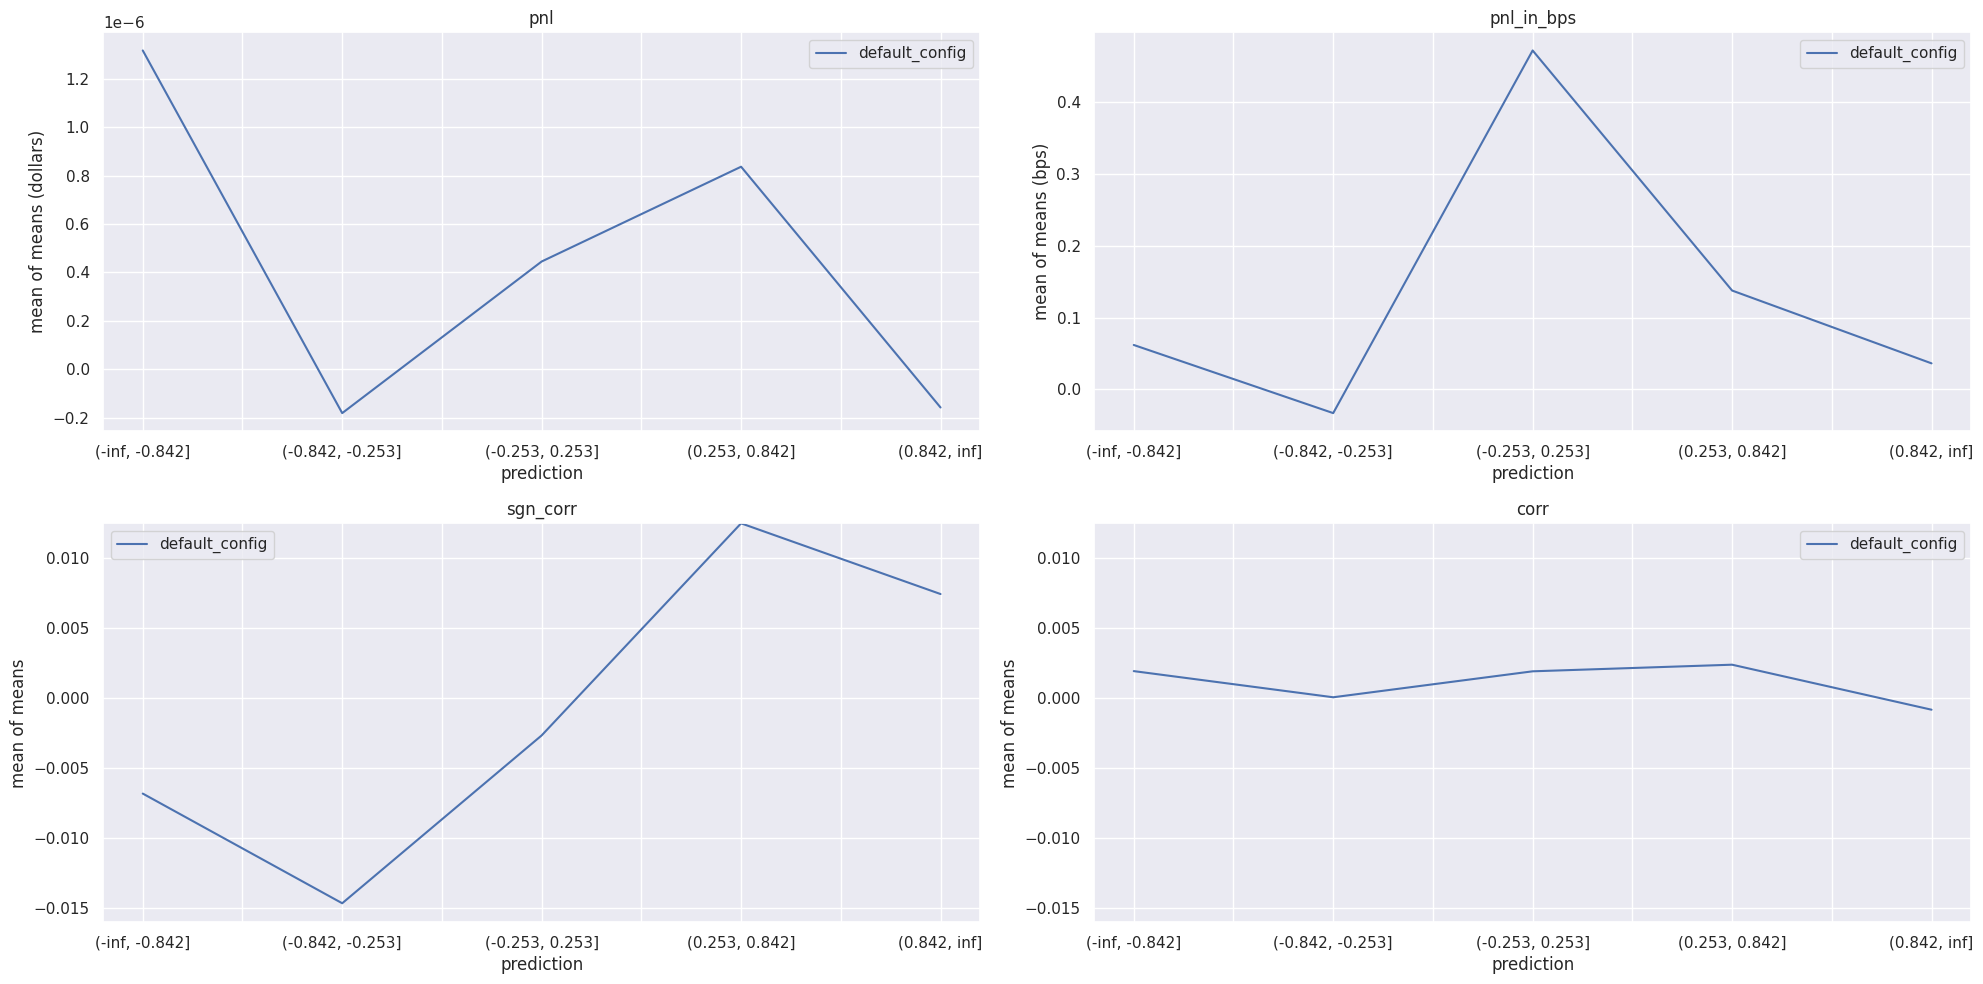

In [16]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **default_config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [17]:
stats_computer = dtfmod.StatsComputer()

In [18]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

default_config
ratios     sharpe_ratio                           1.54
           sharpe_ratio_standard_error            1.48
           sr.tval                                1.05
           sr.pval                                0.30
           kratio                                 1.65
dollar     gmv_mean                               0.34
           gmv_stdev                              0.16
           annualized_mean_return                 0.18
           annualized_volatility                  0.12
           max_drawdown                           0.05
           pnl_mean                               0.00
           pnl_std                                0.01
           turnover_mean                        306.10
           turnover_stdev                       141.70
           market_bias_mean                       0.01
           market_bias_stdev                      0.05
percentage annualized_mean_return                54.59
           annualized_volatility                 35.44
           max_drawdown                          14.63
           pnl_mean                               0.17
           pnl_std                                1.95
           turnover_mean                      90889.45
           turnover_stdev                     42075.53
           market_bias_mean                       2.36
           market_bias_stdev                     15.75